In [72]:
import numpy as np
import string
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pandas as pd
%matplotlib inline

from raw.helpers import *
from raw.embeddings import *

# Testing
As an initial test let's run the RAW-EMbeddings on 2 GB of wwikipedia dump. 6 times (3 times back-forth) with 50 dimensions.

*Note : I am not using any GPU, do not support parallel preocessing yet, didn't optimize loops with cython. Bottom line the code is slow for now.*

In [2]:
%%time
e = RawEmbedding(nEpoch=3,dim=50)
e.train(glob.glob("data/corpora/*"))

CPU times: user 7h 9min 9s, sys: 8min 8s, total: 7h 17min 17s
Wall time: 7h 14min 38s


## Norm
This part is basically what RAW Embeddings add to current word embeddings and **the results are encouraging.**

Before diving into some comparaison it is useful to keep in mind the average norm of our word embeddings.

In [222]:
np.mean(np.linalg.norm(e.embeddings,axis=1))

0.965206082298148

### Large Norm
Let's look at the words with the largest norm. Note that if everything works well these should be the words that are found extremely rarely => do no exist or spelling mistakes. 

In [43]:
largNorm = e.max_norm(k=30)

for w,n in largNorm.items():
    print(w)

theformula
fivehistory
radiatorthese
zealandenglandwalesscotlandirelandfrancethe
franceburton
santorojoining
stateinferior
gamecatching
lestatsavage
customtowards
visiblestrategyexplorationthe
promotedbattle
gamemusicunlike
admiralswilliam
bullsblackhawks
fileschoicechoosing
serviceadministrative
hexesthe
pricebear
meetingtim
planregardless
finlandcommander
ottawathree
labyrinthinealso
mediacurrently
formspoliticalcountries
associationcox
notthousands
cardlabelsone
goodfoundationthe


As hypothesised these are non existant words.

### Small Norm
Let's look at the words with the largest norm. Note that if everything works well these should be the words that are found extremely often and around any other words (i.e don't have a strong meaning associated with them).

In [44]:
smallNorm = e.min_norm(k=30)

for w,n in smallNorm.items():
    print(w)

socorro
linear
september
may
january
december
april
february
august
october
november
march
th
highway
in
the
division
route
of
to
and
state
for
july
a
was
is
united
infantry
new


As hypothesized words that are largely used and often in different context such as : `to`,`of`,`may`,`the`,`in`,`th`(I assume in the sense 6th),`a`,`was`,`for`.

Concerning the months of the year we might think that this is an error in the algorithm. But I believe it is simply an issue in the preprocessing step. To make thing easier I lowercased everywords, which means that `may` and `May` are indistinguishable. Because `may` is one of those words that doesn't carry much meaning it's vector is close to 0, and because all the months should be close to `May=may` they will also be close to 0.

Bottom line : this problem is due to my crude preprocessing, but it actually shows that the algorithm works as expected.

### Norm as a proxy to strength of meaning

In [191]:
def heat_intra_similarity(txt,metric="cosine",**kwargs):
    similarity = e.intra_similarity(txt,metric,**kwargs)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(similarity, dtype=np.bool)
    mask[np.triu_indices_from(mask,k=1)] = True

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(17,9))
    fig.suptitle('{} distance between words. 0 means same, 2 is max.'.format(metric.capitalize()),fontsize=17,weight="bold")
    similarity = pd.DataFrame(similarity,columns = txt.split(), index = txt.split())
    sns.heatmap(similarity,ax=ax,annot=True,yticklabels=True,mask=mask,cmap=cmap,center=1)

Let's look at the norm of different words that have a similar "strength" of meaning.

In [193]:
txt = 'good best excellent amazing strong stronger strongest'
words = txt.split()

for word in words[:4]:  
    print("{} has norm : {}".format(word,np.linalg.norm(e[word])))
print()    
for word in words[4:]:  
    print("{} has norm : {}".format(word,np.linalg.norm(e[word])))
print()    

good has norm : 5.636070931923539e-26
best has norm : 1.306506121273611e-26
excellent has norm : 3.6733504593087096e-22
amazing has norm : 2.193515552505954e-19

strong has norm : 8.356386760349538e-25
stronger has norm : 1.1785683936594214e-21
strongest has norm : 6.017437860851973e-20



From this example is seems that words with a stronger meaning have larger vectors.

Let's now see if the angle of the vectors kind of keep the meaning of the vector as we hypotesized.

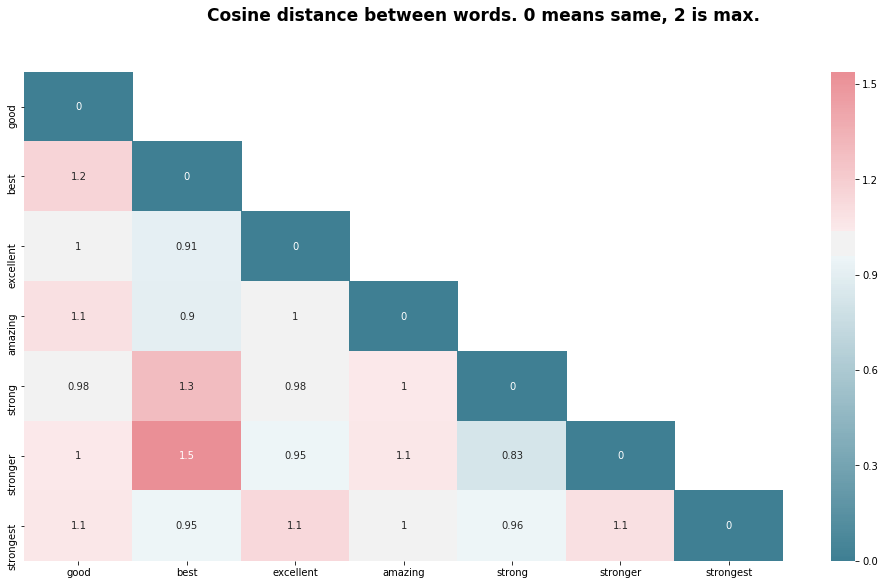

In [194]:
heat_intra_similarity('good best excellent amazing strong stronger strongest',metric="cosine")

We see that the angle seems to keep some kind of semantic siliarity like `best != (strong ~= stronger)` or `best ~= excellent` or `best ~= amazing`. But doesn't as well as the norm encoding the strength and definitely not as well as word2vec or GloVe. This foreshadows the results of the next section. But we should still keep in mind that this is a simple and crude first implementation.

### Norm ~= strength(meaning) or Norm ~= nOccurences ?

A valid question to ask ourselves is whether the norm really encodes the strength of the meaning or does it only encode the nuber of occurences. Indeed we could argue that `strong` occures simply more often than `stronger`. What we really want it to do is to make smaller norm when the words occure in different context. Although teh 2 are  correlated (a word used in many context will often be more used), we should still make teh distinction.

Is the norm always decreasing with the number of occurences ?

In [219]:
n=10000
random_idx = np.random.randint(low=0,high=len(e.embeddings),size=n)
random_words = e._word(list(random_idx))

In [221]:
random_words = [k for k,v in e.hash.items() if v in list(random_idx)]

In [223]:
# dictionnary of {word : (norm,occurence)}
d = {}
for word in random_words:
    d[word] = (np.linalg.norm(e[word]),e.countWords[word])

In [224]:
def n_swaps(l1,l2):
    """Number of swaps to make 2 lists the same."""
    nSwaps = 0
    swapped = set()
    for e1,e2 in zip(l1,l2):
        if e1 != e2 and e1 not in swapped:
            nSwaps += 1
            swapped.add(e1)
            swapped.add(e2)
    return nSwaps

In [225]:
sortNorm = sorted(d.items(), key=lambda t: t[1][0])
sortOcc = sorted(d.items(), key=lambda t: t[1][1]) 

In [226]:
n_swaps(sortNorm,sortOcc)

5986

This shows that the algorithm seems to learn `Norm ~= strength(meaning)` rather than `Norm ~= nOccurences`. Note that all vectors are randomly initalized with a unit vector so the proprety doesn't come from initialization.

## Similarities

This is basically what works so well in current word vectors. If RAW-Embeddings want to improve over current methods they should do so (example results in the **Norm** section, without hindering the results in his section).

### Semantic Neighbours

Let's look at the most similar words to a few querry words based on multiple different metrics.

*Note: I didn't play around at all wiht hyperparameters I simply used some that I thought made sense. So I just want to see whether results seem at least a little encouraging*.

Although I'm testing out multiple different metrics I hypothesize that something simple like L1 or L2 distance should work pretty well. Note that although *cosine similarity* should work relatively well for vectors with large norms, it will probably not be a good metric overall as they might have a similar angle to words with low norms that just happen to have this angle although the algorithm really wants to bring them to 0.

In [3]:
querries = ['cat','dog','germany','man','yellow','computer','kiwi','banana']
metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation','cosine', 'euclidean',
            'hamming', 'jaccard', 'mahalanobis', 'minkowski', 'seuclidean', 'sqeuclidean']

for metric in metrics:
    print("-- {} --".format(metric))
    for word in querries:
        print(word,"|",e.nearest_neigbours(word,metric=metric).keys())
    print()

-- braycurtis --
cat | odict_keys(['disaster', 'spaces', 'acre', 'pc', 'madrid'])
dog | odict_keys(['comprised', 'childrens', 'incident', 'rear', 'identical'])
germany | odict_keys(['computer', 'stations', 'georgia', 'similar', 'standard'])
man | odict_keys(['process', 'reached', 'subject', 'income', 'competition'])
yellow | odict_keys(['dbindexa', 'purchased', 'socialist', 'broken', 'bishop'])
computer | odict_keys(['similar', 'germany', 'ability', 'units', 'start'])
kiwi | odict_keys(['boniface', 'padma', 'puppy', 'witchcraft', 'jesuits'])
banana | odict_keys(['remixes', 'sequels', 'collects', 'contributes', 'lyrical'])

-- canberra --
cat | odict_keys(['reduction', 'yankees', 'keeps', 'mechanical', 'exceptions'])
dog | odict_keys(['seek', 'childrens', 'commissioner', 'assessment', 'statistics'])
germany | odict_keys(['common', 'power', 'operations', 'runs', 'book'])
man | odict_keys(['process', 'scotland', 'hit', 'having', 'although'])
yellow | odict_keys(['opposite', 'universal', '

germany | odict_keys(['stations', 'six', 'band', 'economic', 'great'])
man | odict_keys(['income', 'board', 'census', 'age', 'international'])
yellow | odict_keys(['philippines', 'speech', 'railroad', 'expanded', 'color'])
computer | odict_keys(['similar', 'germany', 'stations', 'six', 'technology'])
kiwi | odict_keys(['boniface', 'puppy', 'jesuits', 'witchcraft', 'valentines'])
banana | odict_keys(['traction', 'plagued', 'drainage', 'remixes', 'jade'])

-- yule --
cat | odict_keys(['authorgoulburn', 'producersrick', 'summergeographythe', 'kuvat', 'duvallstephen', 'programsleadership'])
dog | odict_keys(['authorgoulburn', 'producersrick', 'summergeographythe', 'kuvat', 'duvallstephen', 'programsleadership'])
germany | odict_keys(['authorgoulburn', 'producersrick', 'summergeographythe', 'kuvat', 'duvallstephen', 'programsleadership'])
man | odict_keys(['authorgoulburn', 'producersrick', 'summergeographythe', 'kuvat', 'duvallstephen', 'programsleadership'])
yellow | odict_keys(['authorgo

Although there are some similarities that seem pretty good. For example "yellow"-"color" and "computer"-"technology", it is far from satisfactory for the rest.

### Analogies

In [18]:
testAnalogies = [(['germany', 'paris'],['berlin']),
                 (['woman', 'king'],['man']),
                 (['king', 'princess'],['prince']),
                 (['slow', 'fastest'],['slowest']),
                 (['soft', 'stronger'],['softer'])]

for pos,neg in testAnalogies:
    print("== {} - {} + {} ==".format(pos[0],neg[0],pos[1]))
    for metric in ['cityblock','euclidean','cosine']:
        print("{}:".format(metric),list(e.nearest_analogy(pos=pos,neg=neg,metric=metric,k=8).keys()))
    print()

== germany - berlin + paris ==
cityblock: ['belief', 'scale', 'edition', 'ice', 'trains', 'anyone', 'paris', 'couple', 'cricket']
euclidean: ['belief', 'ice', 'scale', 'affected', 'soul', 'evening', 'briefly', 'weather', 'electric']
cosine: ['pointed', 'belief', 'uno', 'loren', 'duct', 'stop', 'quarterfinals', 'atkinson', 'identification']

== woman - man + king ==
cityblock: ['woman', 'mi', 'almost', 'african', 'base', 'taken', 'policy', 'shows', 'done']
euclidean: ['woman', 'graduate', 'earned', 'industry', 'fourth', 'mi', 'virginia', 'german', 'character']
cosine: ['woman', 'plastic', 'amalgamated', 'cleaning', 'basins', 'additional', 'inflation', 'romanesque', 'utilities']

== king - prince + princess ==
cityblock: ['princess', 'neither', 'carrier', 'zone', 'pressure', 'composed', 'jack', 'sequence', 'equipment']
euclidean: ['princess', 'neither', 'composed', 'sequence', 'exception', 'carrier', 'author', 'jack', 'jews']
cosine: ['princess', 'awoke', 'aloing', 'deunovcardinal', 'jun

The results are feinitely not the ones I was hoping for, but there are still some analogies which seem at least ok (for a crude first implementation with no hyperparameter opt): 
* `germany - berlin + paris = paris` fine if we consider France close to Paris (i.e at least shows that Germany - Berlin ~ 0).
* `king - prince + princess = princess` fine if we consider Queen close to princess (i.e at least shows that king - prince ~ 0).
* `soft - softer + stronger = gladiator` fine if we consider a gladiator to be strong.

In [ ]:
def heat_dic(dic):
    fig, ax = plt.subplots(figsize=(17,9))
    sns.heatmap(dic, ax=ax,annot=False,yticklabels=False)